## 2E-VREC Problem Solver using ALNS

In [31]:
import random
from typing import List, Dict, Set, Tuple,Optional
import numpy as np
from alns import ALNS,State
from alns.accept import SimulatedAnnealing
from alns.select import RouletteWheel
from alns.stop import MaxIterations

import numpy.random as rnd
from scipy.stats import false_discovery_control

SEED = 1234


In [32]:
class VehicleRoute:
    """
    Represents a van or robot route in the 2E-VREC problem.
    """

    def __init__(self, is_van_route: bool = True):
        self.nodes: List[int] = []  # List of nodes in the route
        self.is_van_route: bool = is_van_route
        # Whether robot is on the van for each segment (van routes only)
        self.robot_onboard: List[bool] = []
        # Amount to recharge at each node
        self.recharge_amount: Dict[int, float] = {}
        # Amount to charge en-route (van routes only)
        self.en_route_charge: Dict[Tuple[int, int], float] = {}

    def copy(self) -> "VehicleRoute":
        """Creates a deep copy of the VehicleRoute object."""
        route = VehicleRoute(self.is_van_route)
        route.nodes = self.nodes.copy()
        route.robot_onboard = self.robot_onboard.copy()
        route.recharge_amount = self.recharge_amount.copy()
        route.en_route_charge = self.en_route_charge.copy()
        return route

    def __str__(self) -> str:
        route_type = "Van" if self.is_van_route else "Robot"
        return f"{route_type} Route: {self.nodes}"

In [33]:
class VRPECSolution(State):
    """
    Represents a solution to the 2E-VREC problem.
    """

    def __init__(self,
                 distance_matrix: np.ndarray,
                 depot: int,
                 charging_stations: List[int],
                 customers_robot_only: List[int],
                 customers_both: List[int],
                 van_params: Dict[str, float],
                 robot_params: Dict[str, float],
                 customer_demand: Dict[int, float],
                 time_windows: Dict[int, Tuple[float, float]],
                 service_times: Dict[int, float]):
        # Problem data
        self.distance_matrix: np.ndarray = distance_matrix
        self.depot: int = depot
        self.charging_stations: List[int] = charging_stations
        self.customers_robot_only: List[int] = customers_robot_only
        self.customers_both: List[int] = customers_both
        self.all_customers: List[int] = customers_robot_only + customers_both
        self.van_params: Dict[str, float] = van_params
        self.robot_params: Dict[str, float] = robot_params
        self.customer_demand: Dict[int, float] = customer_demand
        self.time_windows: Dict[int, Tuple[float, float]] = time_windows
        self.service_time:List[float] = service_times

        # Solution data
        self.van_routes: List[VehicleRoute] = []
        self.robot_routes: List[VehicleRoute] = []
        self.unassigned_customers: Set[int] = set(self.all_customers)

    def copy(self) -> "VRPECSolution":
        """Create a deep copy of the solution state."""
        solution = VRPECSolution(
            self.distance_matrix,
            self.depot,
            self.charging_stations,
            self.customers_robot_only,
            self.customers_both,
            self.van_params,
            self.robot_params,
            self.customer_demand,
            self.time_windows,
            self.service_time
        )
        solution.van_routes = [route.copy() for route in self.van_routes]
        solution.robot_routes = [route.copy() for route in self.robot_routes]
        solution.unassigned_customers = self.unassigned_customers.copy()
        return solution

    def objective(self) -> float:
        """
        Tính tổng chi phí của giải pháp, bao gồm chi phí di chuyển và chi phí thời gian.
        """
        total_cost = 0.0

        # **Chi phí di chuyển cho van**
        for route in self.van_routes:
            if len(route.nodes) > 1:
                for i in range(len(route.nodes) - 1):
                    node1, node2 = route.nodes[i], route.nodes[i + 1]
                    distance = self.distance_matrix[node1][node2]
                    total_cost += (self.van_params["travel_cost_rate"] * distance / self.van_params["speed"])

        # **Chi phí di chuyển cho robot**
        for route in self.robot_routes:
            if len(route.nodes) > 1:
                for i in range(len(route.nodes) - 1):
                    node1, node2 = route.nodes[i], route.nodes[i + 1]
                    distance = self.distance_matrix[node1][node2]
                    total_cost += (self.robot_params["travel_cost_rate"] * distance / self.robot_params["speed"])

        
        # **Phạt nếu có khách hàng không được phục vụ**
        for cus in self.unassigned_customers:
            total_cost += self.customer_demand[cus] * 1000

        return total_cost

    def calculate_route_details(self, route: VehicleRoute) -> Tuple[bool, List[float], List[float]]:
    
        params = self.van_params if route.is_van_route else self.robot_params
        speed = params["speed"]
        energy_consumption_rate = params["energy_consumption_rate"]
        battery_capacity = params["battery_capacity"]
        charge_rate = params["charge_rate"]

        arrival_times = [0.0] * len(route.nodes)
        battery_levels = [0.0] * len(route.nodes)
        current_time = 0.0
        current_battery = battery_capacity # Assume vehicles start fully charged at depot/station

        if not route.nodes:
            return True, [], []

        battery_levels[0] = current_battery

        for i in range(len(route.nodes) - 1):
            node_from = route.nodes[i]
            node_to = route.nodes[i+1]

            recharge = route.recharge_amount.get(node_from, 0.0)
            current_battery = min(battery_capacity, current_battery + recharge)
            charging_time = recharge / charge_rate if charge_rate > 0 else 0
            current_time += charging_time

            start_tw_from, end_tw_from = self.time_windows.get(node_from, (0, float('inf')))
            current_time = max(current_time, start_tw_from)
            if current_time > end_tw_from:
                return False, arrival_times, battery_levels

            distance = self.distance_matrix[node_from][node_to]
            travel_time = distance / speed if speed > 0 else float('inf')
            energy_needed = distance * energy_consumption_rate

            # Check if enough battery for the trip
            if current_battery < energy_needed:
                 return False, arrival_times, battery_levels
            current_battery -= energy_needed

            arrival_time_at_to = current_time + travel_time
            arrival_times[i+1] = arrival_time_at_to
            battery_levels[i+1] = current_battery

            # 5. Check arrival time window at node_to
            start_tw_to, end_tw_to = self.time_windows.get(node_to, (0, float('inf')))
            if arrival_time_at_to > end_tw_to:
                return False, arrival_times, battery_levels

            current_time = max(arrival_time_at_to, start_tw_to) + self.service_times.get(node_to, 0.0)

        return True, arrival_times, battery_levels


    def calculate_time_warp(self, route: VehicleRoute, node_idx: int) -> float:
        
        if node_idx >= len(route.nodes) - 1:
            return float('inf') # Lots of time at the end node

        # Calculate earliest possible schedule from the start
        feasible, earliest_arrivals, _ = self.calculate_route_details(route)
        if not feasible:
            return 0.0 # If route isn't feasible to begin with, no time warp

        earliest_arrival_at_node = earliest_arrivals[node_idx]
        node_id = route.nodes[node_idx]
        earliest_start_tw, _ = self.time_windows.get(node_id, (0, float('inf')))
        earliest_departure_time = max(earliest_arrival_at_node, earliest_start_tw) + self.service_times.get(node_id, 0.0)


        next_node_id = route.nodes[node_idx + 1]
        _, latest_arrival_tw_next = self.time_windows.get(next_node_id, (0, float('inf')))

        params = self.van_params if route.is_van_route else self.robot_params
        speed = params["speed"]
        distance = self.distance_matrix[node_id][next_node_id]
        travel_time = distance / speed if speed > 0 else float('inf')

        latest_departure_time = latest_arrival_tw_next - travel_time
        latest_departure_time = max(latest_departure_time, earliest_departure_time)

        time_warp = latest_departure_time - earliest_departure_time
        
        _, end_tw_node = self.time_windows.get(node_id, (0, float('inf')))
        max_wait_time = end_tw_node - earliest_arrival_at_node - self.service_times.get(node_id, 0.0)
        
        # Consider both constraints
        time_warp = max(0.0, min(time_warp, max_wait_time))

        return time_warp


    def find_next_parking_station_idx(self, route: VehicleRoute, current_idx: int) -> Optional[int]:
        """Finds the index of the next parking station in the route after current_idx."""
        for i in range(current_idx + 1, len(route.nodes)):
            node_id = route.nodes[i]
            if node_id == self.depot or node_id in self.charging_stations:
                return i
        return None # Should ideally find the depot at the end

    def calculate_energy_needed(self, route: VehicleRoute, start_idx: int, end_idx: int) -> float:
        """Calculates energy needed to travel from start_idx to end_idx along the route."""
        if start_idx >= end_idx or start_idx < 0 or end_idx >= len(route.nodes):
            return 0.0

        params = self.van_params if route.is_van_route else self.robot_params
        energy_consumption_rate = params["energy_consumption_rate"]
        total_energy = 0.0

        for i in range(start_idx, end_idx):
            node_from = route.nodes[i]
            node_to = route.nodes[i+1]
            distance = self.distance_matrix[node_from][node_to]
            total_energy += distance * energy_consumption_rate
        return total_energy


    def apply_four_step_charging_heuristic(self, route: VehicleRoute):
        route.recharge_amount = {}

        if not route.nodes:
            return

        feasible, arrival_times, battery_on_arrival = self.calculate_route_details(route)

        params = self.van_params if route.is_van_route else self.robot_params
        charge_rate = params["charge_rate"]
        battery_capacity = params["battery_capacity"]

        # Iterate through nodes where charging is possible
        for i in range(len(route.nodes)):
            node_id = route.nodes[i]
            
            # Check if charging is possible at this node
            if not route.is_charging_location(node_id, self):
                 continue
            
            current_battery_arrival = battery_on_arrival[i] # Battery level upon reaching node i
            route.recharge_amount[node_id] = 0.0 # Initialize recharge at this node
            
            time_warp_available = self.calculate_time_warp(route, i)
            remaining_time_warp = time_warp_available

            if remaining_time_warp <= 0:
                 continue # No time to charge

            # --- Step 1: Charge Van to Low-Level ---
            if route.is_van_route:
                next_station_idx = self.find_next_parking_station_idx(route, i)
                if next_station_idx is not None:
                    energy_needed_to_next_station = self.calculate_energy_needed(route, i, next_station_idx)
                    charge_needed_step1 = max(0.0, energy_needed_to_next_station - current_battery_arrival)
                    time_needed_step1 = charge_needed_step1 / charge_rate if charge_rate > 0 else float('inf')

                    actual_charge_time_step1 = min(time_needed_step1, remaining_time_warp)
                    van_charge_step1 = actual_charge_time_step1 * charge_rate

                    route.recharge_amount[node_id] += van_charge_step1
                    remaining_time_warp -= actual_charge_time_step1
                    current_battery_after_step1 = min(battery_capacity, current_battery_arrival + van_charge_step1)
                else:
                     current_battery_after_step1 = current_battery_arrival # No next station found (should be depot)

            # --- Step 2/3: Charge Robot to High/Low-Level ---

            if not route.is_van_route: # If it's a robot route being evaluated
                if i == 0: # Charge at the start station for the whole trip
                    energy_needed_robot_full = self.calculate_energy_needed(route, 0, len(route.nodes) - 1)
                    charge_needed_robot = max(0.0, energy_needed_robot_full - current_battery_arrival) # Robot might arrive with some charge? Assume 0 for now.
                    time_needed_robot = charge_needed_robot / charge_rate if charge_rate > 0 else float('inf')

                    actual_charge_time_robot = min(time_needed_robot, remaining_time_warp)
                    robot_charge_step23 = actual_charge_time_robot * charge_rate

                    route.recharge_amount[node_id] += robot_charge_step23 # Add to robot's own recharge
                    remaining_time_warp -= actual_charge_time_robot
                    current_battery_after_step23 = min(battery_capacity, current_battery_arrival + robot_charge_step23)
                else:
                     current_battery_after_step23 = current_battery_arrival # Only charge robot fully at start


            # --- Step 4: Charge Van to Max-Level ---
            if route.is_van_route and remaining_time_warp > 0:
                charge_needed_to_max = max(0.0, battery_capacity - current_battery_after_step1)
                time_needed_step4 = charge_needed_to_max / charge_rate if charge_rate > 0 else float('inf')

                actual_charge_time_step4 = min(time_needed_step4, remaining_time_warp)
                van_charge_step4 = actual_charge_time_step4 * charge_rate

                route.recharge_amount[node_id] += van_charge_step4
                remaining_time_warp -= actual_charge_time_step4
                # current_battery_after_step4 = min(battery_capacity, current_battery_after_step1 + van_charge_step4)


            # --- Step 5: Charge Robot to Max-Level ---
            if not route.is_van_route and i == 0 and remaining_time_warp > 0: # Only top up robot at start station
                charge_needed_to_max_robot = max(0.0, battery_capacity - current_battery_after_step23)
                time_needed_step5 = charge_needed_to_max_robot / charge_rate if charge_rate > 0 else float('inf')

                actual_charge_time_step5 = min(time_needed_step5, remaining_time_warp)
                robot_charge_step5 = actual_charge_time_step5 * charge_rate

                route.recharge_amount[node_id] += robot_charge_step5
                remaining_time_warp -= actual_charge_time_step5



    def apply_heuristic_to_solution(self):
        for route in self.van_routes:
            self.apply_four_step_charging_heuristic(route)
        for route in self.robot_routes:
             self.apply_four_step_charging_heuristic(route)
             if route.nodes:
                 start_node = route.nodes[0]


    def is_feasible(self) -> bool:
        """
        Check if the solution is feasible:
            - All customers are served
            - Vehicle capacities are respected
            - Energy constraints are respected
            - Every robot can complete its route given battery constraints
            - Time windows are respected
        """
        if self.unassigned_customers:
            return False
        
        if len(self.van_routes) == 0 or len(self.robot_routes) == 0:
            return False
        
        if len(self.van_routes) > 1:
            return False

        return all(self._is_van_route_feasible(route, i)
                   for i, route in enumerate(self.van_routes)) and \
               all(self._is_robot_route_feasible(route, i)
                   for i, route in enumerate(self.robot_routes))

    def _is_van_route_feasible(self, route: VehicleRoute, route_idx: int) -> bool:
        """Check if a van route is feasible."""
        if not route.nodes:
            return True
        if route.nodes[0] != self.depot or route.nodes[-1] != self.depot:
            return False

        # Kiểm tra không có khách hàng sau khách hàng cuối cùng trước depot
        last_customer_idx = -1
        for i in range(len(route.nodes) - 1, 0, -1):
            if route.nodes[i] in self.all_customers:
                last_customer_idx = i
                break
        if last_customer_idx > 0:
            for i in range(last_customer_idx + 1, len(route.nodes) - 1):
                if route.nodes[i] in self.all_customers:
                    return False

        battery_level = self.van_params["battery_capacity"]
        load = 0
        for i in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[i], route.nodes[i + 1]
            if node1 in self.all_customers:
                load += self.customer_demand[node1]
            distance = self.distance_matrix[node1][node2]
            energy_consumption = (distance / self.van_params["speed"]) * self.van_params["energy_consumption_rate"]
            en_route_charge = route.en_route_charge.get((node1, node2), 0)
            if node1 in self.charging_stations:
                recharge_amount = route.recharge_amount.get(node1, 0)
                battery_level = min(battery_level + recharge_amount, self.van_params["battery_capacity"])
            if battery_level < energy_consumption + en_route_charge:
                return False
            battery_level -= energy_consumption + en_route_charge
        return load <= self.van_params["capacity"]

    def _is_robot_route_feasible(self, route: VehicleRoute, route_idx: int) -> bool:
        """Check if a robot route is feasible."""
        if not route.nodes:
            return True
        if (route.nodes[0] not in self.charging_stations or
                route.nodes[-1] not in self.charging_stations):
            return False

        battery_level = route.recharge_amount.get(route.nodes[0], 0)
        load = 0
        for i in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[i], route.nodes[i + 1]
            if node1 in self.all_customers:
                load += self.customer_demand[node1]
            distance = self.distance_matrix[node1][node2]
            energy_consumption = (distance / self.robot_params["speed"]) * self.robot_params["energy_consumption_rate"]
            if node1 in self.charging_stations:
                recharge_amount = route.recharge_amount.get(node1, 0)
                battery_level = min(battery_level + recharge_amount, self.robot_params["battery_capacity"])
            battery_level -= energy_consumption
            if battery_level < 0:
                return False
        return load <= self.robot_params["capacity"]

    def _can_van_visit_customer(self, route: VehicleRoute, customer: int) -> bool:
        """Check if a van can visit a customer directly."""
        if customer in self.customers_robot_only:
            return False
        return self.customer_demand[customer] <= self.van_params["capacity"]

    def create_initial_solution(self) -> "VRPECSolution":
        """
        Create an initial feasible solution. Uses a simple greedy approach
        to assign customers to routes.
        """
        solution = self.copy()
        solution.unassigned_customers = set(self.all_customers)
        van_route = VehicleRoute(is_van_route=True)
        van_route.nodes = [self.depot]
        station_distances = [(s, self.distance_matrix[self.depot][s])
                             for s in self.charging_stations]
        station_distances.sort(key=lambda x: x[1])
        closest_station = station_distances[0][0]
        van_route.nodes.append(closest_station)
        van_route.robot_onboard = [True]
        robot_route = VehicleRoute(is_van_route=False)
        robot_route.nodes = [closest_station]
        customers_to_visit = list(solution.unassigned_customers)
        customers_to_visit.sort(key=lambda c: self.distance_matrix[closest_station][c])
        total_load = 0
        for customer in customers_to_visit:
            if customer in solution.customers_both:
                if random.random() < 0.5 and self._can_van_visit_customer(van_route, customer):
                    van_route.nodes.insert(-1, customer)
                    van_route.robot_onboard.append(True)
                    solution.unassigned_customers.remove(customer)
                    continue
            if total_load + self.customer_demand[customer] <= self.robot_params["capacity"]:
                robot_route.nodes.append(customer)
                total_load += self.customer_demand[customer]
                solution.unassigned_customers.remove(customer)
        robot_route.nodes.append(closest_station)
        van_route.nodes.append(self.depot)
        van_route.robot_onboard.append(True)
        van_route.recharge_amount[closest_station] = self.van_params["battery_capacity"] / 2
        robot_route.recharge_amount[closest_station] = self.robot_params["battery_capacity"]
        solution.van_routes.append(van_route)
        solution.robot_routes.append(robot_route)
        while solution.unassigned_customers:
            new_van_route = VehicleRoute(is_van_route=True)
            new_van_route.nodes = [self.depot, closest_station, self.depot]
            new_van_route.robot_onboard = [True, True]
            new_robot_route = VehicleRoute(is_van_route=False)
            new_robot_route.nodes = [closest_station]
            customers_to_visit = list(solution.unassigned_customers)
            customers_to_visit.sort(key=lambda c: self.distance_matrix[closest_station][c])
            total_load = 0
            for customer in customers_to_visit:
                if total_load + self.customer_demand[customer] <= self.robot_params["capacity"]:
                    new_robot_route.nodes.append(customer)
                    total_load += self.customer_demand[customer]
                    solution.unassigned_customers.remove(customer)
            if len(new_robot_route.nodes) > 1:
                new_robot_route.nodes.append(closest_station)
                new_robot_route.recharge_amount[closest_station] = self.robot_params["battery_capacity"]
                new_van_route.recharge_amount[closest_station] = self.van_params["battery_capacity"] / 2
                solution.van_routes.append(new_van_route)
                solution.robot_routes.append(new_robot_route)
            else:
                break
        return solution


In [34]:

def random_customer_removal(solution: VRPECSolution,
                            random_state: np.random.RandomState) -> VRPECSolution:
    """
    Remove a random customer from the solution.
    """
    destroyed = solution.copy()
    assigned_customers = [c for c in destroyed.all_customers
                          if c not in destroyed.unassigned_customers]

    if not assigned_customers:
        return destroyed  # No customers to remove

    customer_to_remove = random_state.choice(assigned_customers)

    for route in destroyed.van_routes:
        if customer_to_remove in route.nodes:
            idx = route.nodes.index(customer_to_remove)
            route.nodes.pop(idx)
            if idx < len(route.robot_onboard):
                route.robot_onboard.pop(idx)

    for route in destroyed.robot_routes:
        if customer_to_remove in route.nodes:
            route.nodes.remove(customer_to_remove)

    destroyed.unassigned_customers.add(customer_to_remove)
    return destroyed


def station_removal(solution: VRPECSolution,
                    random_state: np.random.RandomState) -> VRPECSolution:
    """
    Remove a random charging station and its associated robot routes.
    """
    destroyed = solution.copy()
    used_stations = set()
    for route in destroyed.van_routes:
        for node in route.nodes:
            if node in destroyed.charging_stations:
                used_stations.add(node)

    if not used_stations:
        return destroyed  # No stations to remove

    station_to_remove = random_state.choice(list(used_stations))

    routes_to_remove = []
    for i, route in enumerate(destroyed.robot_routes):
        if station_to_remove in route.nodes:
            routes_to_remove.append(i)
            for node in route.nodes:
                if node in destroyed.all_customers:
                    destroyed.unassigned_customers.add(node)

    for i in sorted(routes_to_remove, reverse=True):
        destroyed.robot_routes.pop(i)

    for route in destroyed.van_routes:
        if station_to_remove in route.nodes:
            idx = route.nodes.index(station_to_remove)
            if 0 < idx < len(route.nodes) - 1:
                route.nodes.pop(idx)
                if idx < len(route.robot_onboard):
                    route.robot_onboard.pop(idx)

    return destroyed


def route_destruction(solution: VRPECSolution,
                      random_state: np.random.RandomState) -> VRPECSolution:
    """
    Destroy a random van route and its associated robot routes.
    """
    destroyed = solution.copy()
    if not destroyed.van_routes:
        return destroyed  # Nocustomer_demand routes to destroy

    van_route_idx = random_state.randint(0, len(destroyed.van_routes))

    if van_route_idx < len(destroyed.van_routes):
        van_route = destroyed.van_routes[van_route_idx]

        for node in van_route.nodes:
            if node in destroyed.all_customers:
                destroyed.unassigned_customers.add(node)

        stations_in_route = [node for node in van_route.nodes
                             if node in destroyed.charging_stations]

        routes_to_remove = []
        for i, route in enumerate(destroyed.robot_routes):
            if any(station in route.nodes for station in stations_in_route):
                routes_to_remove.append(i)
                for node in route.nodes:
                    if node in destroyed.all_customers:
                        destroyed.unassigned_customers.add(node)

        for i in sorted(routes_to_remove, reverse=True):
            destroyed.robot_routes.pop(i)

        destroyed.van_routes.pop(van_route_idx)

    return destroyed

In [35]:
def greedy_repair(solution: VRPECSolution,
                  random_state: np.random.RandomState) -> VRPECSolution:
    """
    Repair by greedily inserting unassigned customers into existing routes.
    """
    repaired = solution.copy()
    unassigned = list(repaired.unassigned_customers)
    random_state.shuffle(unassigned)

    for customer in unassigned:
        best_cost = float('inf')
        best_insert = None

        # Try to insert into van routes
        if customer in repaired.customers_both:
            for r_idx, route in enumerate(repaired.van_routes):
                for pos in range(1, len(route.nodes)):
                    prev_node, next_node = route.nodes[pos - 1], route.nodes[pos]
                    old_cost = (repaired.van_params["travel_cost_rate"] *
                                repaired.distance_matrix[prev_node][next_node])
                    new_cost = (repaired.van_params["travel_cost_rate"] *
                                (repaired.distance_matrix[prev_node][customer] +
                                 repaired.distance_matrix[customer][next_node]))
                    delta = new_cost - old_cost

                    if delta < best_cost:
                        temp_route = route.copy()
                        temp_route.nodes.insert(pos, customer)
                        temp_route.robot_onboard.insert(
                            pos - 1,
                            (route.robot_onboard[pos - 1]
                             if pos - 1 < len(route.robot_onboard) else False)
                        )

                        if repaired._is_van_route_feasible(temp_route, r_idx):
                            best_cost = delta
                            best_insert = ('van', r_idx, pos)

        # Try to insert into robot routes
        for r_idx, route in enumerate(repaired.robot_routes):
            for pos in range(1, len(route.nodes)):
                prev_node, next_node = route.nodes[pos - 1], route.nodes[pos]
                old_cost = (repaired.robot_params["travel_cost_rate"] *
                            repaired.distance_matrix[prev_node][next_node])
                new_cost = (repaired.robot_params["travel_cost_rate"] *
                            (repaired.distance_matrix[prev_node][customer] +
                             repaired.distance_matrix[customer][next_node]))
                delta = new_cost - old_cost

                if delta < best_cost:
                    temp_route = route.copy()
                    temp_route.nodes.insert(pos, customer)

                    if repaired._is_robot_route_feasible(temp_route, r_idx):
                        best_cost = delta
                        best_insert = ('robot', r_idx, pos)

        if best_insert:
            route_type, r_idx, pos = best_insert
            if route_type == 'van':
                repaired.van_routes[r_idx].nodes.insert(pos, customer)
                repaired.van_routes[r_idx].robot_onboard.insert(
                    pos - 1,
                    (repaired.van_routes[r_idx].robot_onboard[pos - 1]
                     if pos - 1 < len(repaired.van_routes[r_idx].robot_onboard)
                     else False)
                )
            else:  # robot
                repaired.robot_routes[r_idx].nodes.insert(pos, customer)
            repaired.unassigned_customers.remove(customer)
        else:
            # Create a new route (van or robot)
            if customer in repaired.customers_both:
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [repaired.depot, customer, repaired.depot]
                new_van_route.robot_onboard = [False, False]

                if repaired._is_van_route_feasible(new_van_route,
                                                  len(repaired.van_routes)):
                    repaired.van_routes.append(new_van_route)
                    repaired.unassigned_customers.remove(customer)
                    continue

            # Try to extend an existing van route to a charging station
            best_extension_cost = float('inf')
            best_extension = None
            
            # First find best charging station for this customer
            station_distances = [
                (s, repaired.distance_matrix[customer][s])
                for s in repaired.charging_stations
            ]
            station_distances.sort(key=lambda x: x[1])
            
            # Try extending existing van routes to appropriate charging stations
            for cs_idx, (charging_station, _) in enumerate(station_distances):
                # Only check the closest few stations
                if cs_idx > 2:  # Limit to checking top 3 closest stations
                    break
                
                # Try adding to existing routes with robots
                for r_idx, route in enumerate(repaired.van_routes):
                    if not any(route.robot_onboard):
                        continue  # Skip routes without robots
                    
                    # Check if charging station is already in the route
                    if charging_station in route.nodes:
                        continue
                        
                    # Try inserting charging station at each position
                    for pos in range(1, len(route.nodes)):
                        prev_node, next_node = route.nodes[pos-1], route.nodes[pos]
                        
                        # Cost of detour to visit this charging station
                        detour_cost = (
                            repaired.distance_matrix[prev_node][charging_station] + 
                            repaired.distance_matrix[charging_station][next_node] -
                            repaired.distance_matrix[prev_node][next_node]
                        ) * repaired.van_params["travel_cost_rate"]
                        
                        if detour_cost < best_extension_cost:
                            temp_route = route.copy()
                            temp_route.nodes.insert(pos, charging_station)
                            temp_route.robot_onboard.insert(pos-1, True)
                            temp_route.robot_onboard.insert(pos, True)
                            
                            # Set recharging at the station
                            temp_route.recharge_amount[charging_station] = (
                                repaired.van_params["battery_capacity"] / 2)
                            
                            if repaired._is_van_route_feasible(temp_route, r_idx):
                                # Check if robot route would be feasible
                                new_robot_route = VehicleRoute(is_van_route=False)
                                new_robot_route.nodes = [charging_station, customer, charging_station]
                                new_robot_route.recharge_amount[charging_station] = (
                                    repaired.robot_params["battery_capacity"])
                                
                                if repaired._is_robot_route_feasible(new_robot_route, 
                                                              len(repaired.robot_routes)):
                                    best_extension_cost = detour_cost
                                    best_extension = (r_idx, pos, charging_station)
            
            # If we found a good extension, use it
            if best_extension:
                r_idx, pos, station = best_extension
                
                # Update van route
                repaired.van_routes[r_idx].nodes.insert(pos, station)
                repaired.van_routes[r_idx].robot_onboard.insert(pos-1, True)
                repaired.van_routes[r_idx].robot_onboard.insert(pos, True)
                repaired.van_routes[r_idx].recharge_amount[station] = (
                    repaired.van_params["battery_capacity"] / 2)
                
                # Create new robot route
                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [station, customer, station]
                new_robot_route.recharge_amount[station] = repaired.robot_params["battery_capacity"]
                repaired.robot_routes.append(new_robot_route)
                repaired.unassigned_customers.remove(customer)
                continue
                
            # If no good extension, create a new route
            for charging_station, _ in station_distances:
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [repaired.depot, charging_station, repaired.depot]
                new_van_route.robot_onboard = [True, True]
                new_van_route.recharge_amount[charging_station] = (
                    repaired.van_params["battery_capacity"] / 2)

                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [charging_station, customer, charging_station]
                new_robot_route.recharge_amount[charging_station] = (
                    repaired.robot_params["battery_capacity"])

                if (repaired._is_van_route_feasible(
                        new_van_route, len(repaired.van_routes)) and
                        repaired._is_robot_route_feasible(
                            new_robot_route, len(repaired.robot_routes))):
                    repaired.van_routes.append(new_van_route)
                    repaired.robot_routes.append(new_robot_route)
                    repaired.unassigned_customers.remove(customer)
                    break  # Added, move to next customer

    return repaired


def route_reconstruction(solution: VRPECSolution,
                         random_state: np.random.RandomState) -> VRPECSolution:
    """
    Reconstruct routes for all unassigned customers.
    """
    reconstructed = solution.copy()
    if not reconstructed.unassigned_customers:
        return reconstructed

    unassigned = list(reconstructed.unassigned_customers)
    unassigned.sort(key=lambda c: reconstructed.customer_demand[c],
                    reverse=True)  # Sort by demand (descending)

    # Group customers by region/proximity
    if len(unassigned) > 1:
        # Use simple clustering by nearest charging station
        customer_groups = {}
        for customer in unassigned:
            nearest_station = min(
                reconstructed.charging_stations,
                key=lambda s: reconstructed.distance_matrix[customer][s]
            )
            if nearest_station not in customer_groups:
                customer_groups[nearest_station] = []
            customer_groups[nearest_station].append(customer)
    else:
        # Just one customer
        customer_groups = {0: unassigned}

    # Process each group
    for station, customers in customer_groups.items():
        # First try to add customers to existing robot routes
        for customer in customers[:]:  # Work with a copy to allow removals
            best_insert_cost = float('inf')
            best_robot_route = None
            best_pos = None
            
            for r_idx, route in enumerate(reconstructed.robot_routes):
                # Only consider routes that start/end at the appropriate station
                if route.nodes[0] != station:
                    continue
                    
                for pos in range(1, len(route.nodes)):
                    prev, next_node = route.nodes[pos-1], route.nodes[pos]
                    old_cost = reconstructed.distance_matrix[prev][next_node]
                    new_cost = (reconstructed.distance_matrix[prev][customer] +
                               reconstructed.distance_matrix[customer][next_node])
                    delta = new_cost - old_cost
                    
                    if delta < best_insert_cost:
                        temp_route = route.copy()
                        temp_route.nodes.insert(pos, customer)
                        
                        if reconstructed._is_robot_route_feasible(temp_route, r_idx):
                            best_insert_cost = delta
                            best_robot_route = r_idx
                            best_pos = pos
            
            if best_robot_route is not None:
                reconstructed.robot_routes[best_robot_route].nodes.insert(best_pos, customer)
                customers.remove(customer)
                reconstructed.unassigned_customers.remove(customer)

        # For remaining customers, try direct van delivery or new robot routes
        for customer in customers:
            if (customer in reconstructed.customers_both and
                    random_state.random() < 0.5):
                # Try to use van directly
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [reconstructed.depot, customer,
                                      reconstructed.depot]
                new_van_route.robot_onboard = [False, False]

                if reconstructed._is_van_route_feasible(
                        new_van_route, len(reconstructed.van_routes)):
                    reconstructed.van_routes.append(new_van_route)
                    reconstructed.unassigned_customers.remove(customer)
                    continue

            # Try to extend an existing van route to this station
            best_extension_cost = float('inf')
            best_extension = None
            
            for r_idx, route in enumerate(reconstructed.van_routes):
                if station in route.nodes:
                    continue  # Station already in route
                    
                for pos in range(1, len(route.nodes)):
                    prev_node, next_node = route.nodes[pos-1], route.nodes[pos]
                    
                    detour_cost = (
                        reconstructed.distance_matrix[prev_node][station] + 
                        reconstructed.distance_matrix[station][next_node] -
                        reconstructed.distance_matrix[prev_node][next_node]
                    ) * reconstructed.van_params["travel_cost_rate"]
                    
                    if detour_cost < best_extension_cost:
                        temp_route = route.copy()
                        temp_route.nodes.insert(pos, station)
                        
                        # Extend robot_onboard list consistently
                        robot_insertion_idx = pos - 1
                        if robot_insertion_idx < len(route.robot_onboard):
                            robot_onboard_val = route.robot_onboard[robot_insertion_idx]
                            temp_route.robot_onboard.insert(robot_insertion_idx, robot_onboard_val)
                            temp_route.robot_onboard.insert(robot_insertion_idx + 1, True)
                        else:
                            temp_route.robot_onboard.append(True)
                        
                        temp_route.recharge_amount[station] = (
                            reconstructed.van_params["battery_capacity"] / 2)
                        
                        if reconstructed._is_van_route_feasible(temp_route, r_idx):
                            best_extension_cost = detour_cost
                            best_extension = (r_idx, pos)
            
            if best_extension:
                r_idx, pos = best_extension
                # Update van route
                reconstructed.van_routes[r_idx].nodes.insert(pos, station)
                
                # Update robot_onboard list
                robot_insertion_idx = pos - 1
                if robot_insertion_idx < len(reconstructed.van_routes[r_idx].robot_onboard):
                    robot_onboard_val = reconstructed.van_routes[r_idx].robot_onboard[robot_insertion_idx]
                    reconstructed.van_routes[r_idx].robot_onboard.insert(robot_insertion_idx, robot_onboard_val)
                    reconstructed.van_routes[r_idx].robot_onboard.insert(robot_insertion_idx + 1, True)
                else:
                    reconstructed.van_routes[r_idx].robot_onboard.append(True)
                
                reconstructed.van_routes[r_idx].recharge_amount[station] = (
                    reconstructed.van_params["battery_capacity"] / 2)
                
                # Create new robot route
                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [station, customer, station]
                new_robot_route.recharge_amount[station] = (
                    reconstructed.robot_params["battery_capacity"])
                
                reconstructed.robot_routes.append(new_robot_route)
                reconstructed.unassigned_customers.remove(customer)
                continue

            # Need to use a robot with new van route, find appropriate station
            station_distances = [
                (s, reconstructed.distance_matrix[customer][s])
                for s in reconstructed.charging_stations
            ]
            station_distances.sort(key=lambda x: x[1])

            for station, _ in station_distances:
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [reconstructed.depot, station,
                                      reconstructed.depot]
                new_van_route.robot_onboard = [True, True]
                new_van_route.recharge_amount[station] = (
                    reconstructed.van_params["battery_capacity"] / 2)

                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [station, customer, station]
                new_robot_route.recharge_amount[station] = (
                    reconstructed.robot_params["battery_capacity"])

                if (reconstructed._is_van_route_feasible(
                        new_van_route, len(reconstructed.van_routes)) and
                        reconstructed._is_robot_route_feasible(
                            new_robot_route, len(reconstructed.robot_routes))):
                    reconstructed.van_routes.append(new_van_route)
                    reconstructed.robot_routes.append(new_robot_route)
                    reconstructed.unassigned_customers.remove(customer)
                    break

    return reconstructed 

In [36]:
distance_matrix = np.array([
    [0, 50, 80, 80, 50, 80, 80, 82, 84, 86],  # depot 0
    [50, 0, 80, 80, 80, 80, 50, 50, 90, 90],  # station 1
    [80, 70, 0, 50, 80, 80, 80, 80, 80, 80],  # station 2
    [80, 80, 50, 0, 50, 80, 50, 50, 80, 80],  # station 3
    [50, 80, 80, 50, 0, 70, 90, 80, 30, 30],  # station 4
    [80, 80, 80, 80, 70, 0, 80, 80, 80, 80],  # station 5
    [80, 50, 80, 50, 90, 80, 0, 80, 90, 90],  # customer 6
    [82, 50, 80, 50, 80, 80, 80, 0, 90, 90],  # customer 7
    [84, 90, 80, 80, 30, 80, 90, 90, 0, 30],  # customer 8
    [86, 90, 80, 80, 30, 80, 90, 90, 30, 0]  # customer 9
])
# nodes = list(range(len(distance_matrix)))  # Not needed
depot = 0
charging_stations = [1, 2, 3, 4, 5]
customers_robot_only = [6, 8, 9]
customers_both = [7]

van_params = {
    "speed": 2.0,
    "battery_capacity": 200.0,
    "capacity": 200.0,
    "travel_cost_rate": 2.0,
    "energy_consumption_rate": 2.0,
    "charge_rate": 10.0
}

robot_params = {
    "speed": 1.0,
    "battery_capacity": 120.0,
    "capacity": 50.0,
    "travel_cost_rate": 1.0,
    "energy_consumption_rate": 1.0,
    "charge_rate": 4.0
}

customer_demand = {
    6: 15,
    7: 20,
    8: 10,
    9: 25
}

time_windows = {
    0: (0, 500),   # Depot
    1: (0, 500),   # Charging station
    2: (0, 500),   # Charging station
    3: (0, 500),   # Charging station
    4: (0, 500),   # Charging station
    5: (0, 500),   # Charging station
    6: (50, 200), # Customer
    7: (50, 200), # Customer
    8: (50, 400), # Customer
    9: (50, 400)  # Customer
}

service_time = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 10,
    7: 10,
    8: 10,
    9: 10
}

problem = VRPECSolution(
    distance_matrix=distance_matrix,
    depot=depot,
    charging_stations=charging_stations,
    customers_robot_only=customers_robot_only,
    customers_both=customers_both,
    van_params=van_params,
    robot_params=robot_params,
    customer_demand=customer_demand,
    time_windows=time_windows,
    service_times=service_time
)

initial_solution = problem.create_initial_solution()

from functools import partial

alns = ALNS(rnd.default_rng(SEED))

# Create partial functions with required arguments bound
random_customer_removal_partial = partial(
    random_customer_removal,
    distance_matrix=distance_matrix,
    time_windows=time_windows,
    speed_van=van_params["speed"],
    speed_robot=robot_params["speed"]
)

# Assuming similar parameters for other operators
station_removal_partial = partial(
    station_removal,
    distance_matrix=distance_matrix,
    time_windows=time_windows,
    speed_van=van_params["speed"],
    speed_robot=robot_params["speed"]
)

route_destruction_partial = partial(
    route_destruction,
    distance_matrix=distance_matrix,
    time_windows=time_windows,
    speed_van=van_params["speed"],
    speed_robot=robot_params["speed"]
)

greedy_repair_partial = partial(
    greedy_repair,
    distance_matrix=distance_matrix,
    time_windows=time_windows,
    speed_van=van_params["speed"],
    speed_robot=robot_params["speed"]
)

route_reconstruction_partial = partial(
    route_reconstruction,
    distance_matrix=distance_matrix,
    time_windows=time_windows,
    speed_van=van_params["speed"],
    speed_robot=robot_params["speed"]
)

# Add the partial functions as operators
alns.add_destroy_operator(random_customer_removal)
alns.add_destroy_operator(station_removal)
alns.add_destroy_operator(route_destruction)

alns.add_repair_operator(greedy_repair)
alns.add_repair_operator(route_reconstruction)

select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = SimulatedAnnealing(
        start_temperature=100,
        end_temperature=1,
        step=0.99,
        method="exponential"
    )
stop = MaxIterations(1000)

result = alns.iterate(initial_solution, select, accept, stop)
best_solution = result.best_state

print(f"Best solution objective value: {best_solution.objective()}")

print("\nVan Routes:")
for i, route in enumerate(best_solution.van_routes):
    print(f"  Route {i + 1}: {route.nodes}")
    print(f"    Robot onboard: {route.robot_onboard}")
    print(f"    Recharge amounts: {route.recharge_amount}")
    print(f"    En-route charging: {route.en_route_charge}")

print("\nRobot Routes:")
for i, route in enumerate(best_solution.robot_routes):
    print(f"  Route {i + 1}: {route.nodes}")
    print(f"    Recharge amounts: {route.recharge_amount}")

print(f"\nUnassigned customers: {best_solution.unassigned_customers}")


Best solution objective value: 440.0

Van Routes:
  Route 1: [0, 4, 3, np.int64(7), 1, 0]
    Robot onboard: [True, True, True, True, True, True, True]
    Recharge amounts: {1: 100.0, 3: 100.0, 4: 100.0}
    En-route charging: {}

Robot Routes:
  Route 1: [1, 1]
    Recharge amounts: {1: 120.0}
  Route 2: [3, np.int64(6), 3]
    Recharge amounts: {3: 120.0}
  Route 3: [4, np.int64(8), np.int64(9), 4]
    Recharge amounts: {4: 120.0}

Unassigned customers: set()


C:\Users\NAM\AppData\Local\Temp\ipykernel_14020\1423148725.py:183: RuntimeWarning: invalid value encountered in scalar divide
  plt.arrow(mid_x-dx*0.1/arrow_len, mid_y-dy*0.1/arrow_len,
C:\Users\NAM\AppData\Local\Temp\ipykernel_14020\1423148725.py:184: RuntimeWarning: invalid value encountered in scalar divide
  dx*0.2/arrow_len, dy*0.2/arrow_len,


<Axes: title={'center': '2E-VREC Solution Visualization'}>

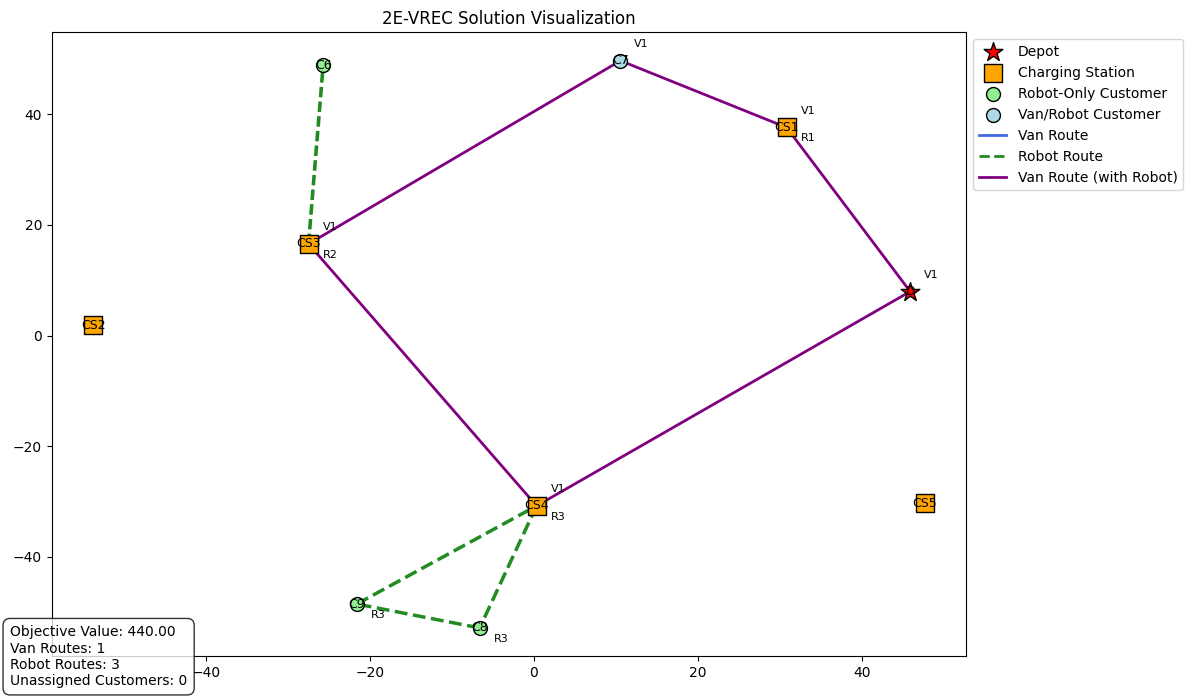

In [37]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def visualize_solution(solution, node_positions=None, figsize=(12, 10), save_path=None):
    """
    Visualize a VRPECSolution showing depot, charging stations, customers and routes.
    
    Parameters:
        solution: VRPECSolution object with the routing solution
        node_positions: Dict mapping node IDs to (x, y) coordinates. If None, will be generated using MDS.
        figsize: Size of the figure (width, height) in inches
        save_path: If provided, save the figure to this path
    """
    # Generate positions if not provided
    if node_positions is None:
        # Use MDS to transform distance matrix to 2D coordinates
        n_nodes = solution.distance_matrix.shape[0]
        
        # Make distance matrix symmetric by averaging with its transpose
        symmetric_distance_matrix = (solution.distance_matrix + solution.distance_matrix.T) / 2
        
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
        positions = mds.fit_transform(symmetric_distance_matrix)
        node_positions = {i: (positions[i, 0], positions[i, 1]) for i in range(n_nodes)}
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Define colors
    van_color = 'royalblue'
    robot_color = 'forestgreen'
    van_robot_color = 'purple'  # For when robot is on board
    
    # Plot nodes
    # Depot
    depot_x, depot_y = node_positions[solution.depot]
    plt.scatter(depot_x, depot_y, c='red', s=200, marker='*', edgecolors='black', zorder=10, label='Depot')
    
    # Charging stations
    station_x = [node_positions[s][0] for s in solution.charging_stations]
    station_y = [node_positions[s][1] for s in solution.charging_stations]
    plt.scatter(station_x, station_y, c='orange', s=150, marker='s', edgecolors='black', zorder=9, label='Charging Station')
    
    # Customers - robot only
    robot_only_x = [node_positions[c][0] for c in solution.customers_robot_only]
    robot_only_y = [node_positions[c][1] for c in solution.customers_robot_only]
    plt.scatter(robot_only_x, robot_only_y, c='lightgreen', s=100, marker='o', edgecolors='black', zorder=8, 
                label='Robot-Only Customer')
    
    # Customers - both van and robot
    both_x = [node_positions[c][0] for c in solution.customers_both]
    both_y = [node_positions[c][1] for c in solution.customers_both]
    plt.scatter(both_x, both_y, c='lightblue', s=100, marker='o', edgecolors='black', zorder=8,
                label='Van/Robot Customer')
    
    # Keep track of robot segments and bidirectional segments
    robot_segments = set()
    robot_bidirectional = set()  # To track segments used in both directions
    
    # First identify all robot segments and find bidirectional ones
    for route in solution.robot_routes:
        if len(route.nodes) <= 1:
            continue
        
        for j in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[j], route.nodes[j + 1]
            segment = (min(node1, node2), max(node1, node2))
            
            if segment in robot_segments:
                robot_bidirectional.add(segment)
            else:
                robot_segments.add(segment)
    
    # Plot routes
    # Van routes first
    for i, route in enumerate(solution.van_routes):
        if len(route.nodes) <= 1:
            continue
        
        for j in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[j], route.nodes[j + 1]
            segment = (min(node1, node2), max(node1, node2))
            x1, y1 = node_positions[node1]
            x2, y2 = node_positions[node2]
            
            # Skip if this is also part of a robot route - we'll draw it later
            if segment in robot_segments:
                continue
                
            # Check if robot is onboard
            robot_onboard = False
            if j < len(route.robot_onboard) and route.robot_onboard[j]:
                color = van_robot_color
                robot_onboard = True
            else:
                color = van_color
            
            plt.plot([x1, x2], [y1, y2], c=color, linewidth=2, zorder=5)
            
            # Add arrow to show direction
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            dx = x2 - x1
            dy = y2 - y1
            arrow_len = np.sqrt(dx**2 + dy**2)
            plt.arrow(mid_x - dx*0.1/arrow_len, mid_y - dy*0.1/arrow_len, 
                      dx*0.2/arrow_len, dy*0.2/arrow_len, 
                      head_width=0.015, head_length=0.03, fc=color, ec=color, zorder=6)
            
            # Annotate route number
            plt.annotate(f"V{i+1}", (x1, y1), xytext=(10, 10), 
                        textcoords='offset points', fontsize=8, zorder=7)
    
    # Robot routes - draw these last to ensure they appear above van routes
    # Track drawn segments to avoid duplicates in bidirectional routes
    drawn_robot_segments = set()
    
    for i, route in enumerate(solution.robot_routes):
        if len(route.nodes) <= 1:
            continue
        
        for j in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[j], route.nodes[j + 1]
            segment = (min(node1, node2), max(node1, node2))
            
            # Skip if we've already drawn this segment (applies to bidirectional)
            if segment in drawn_robot_segments:
                continue
                
            x1, y1 = node_positions[node1]
            x2, y2 = node_positions[node2]
            
            # Use a different dash pattern for bidirectional segments
            if segment in robot_bidirectional:
                # Create curved line for bidirectional path to show both directions
                # First, get the perpendicular offset direction
                dx = x2 - x1
                dy = y2 - y1
                length = np.sqrt(dx**2 + dy**2)
                
                # Normalize and get perpendicular vector
                nx = -dy/length * 0.05  # Small offset
                ny = dx/length * 0.05
                
                # Create curved paths for both directions
                # First direction
                plt.plot([x1+nx, x2+nx], [y1+ny, y2+ny], 
                         c=robot_color, linewidth=2, linestyle='--', zorder=7)
                
                # Second direction
                plt.plot([x1-nx, x2-nx], [y1-ny, y2-ny], 
                         c=robot_color, linewidth=2, linestyle='--', zorder=7)
                
                # Add arrows for both directions
                mid_x, mid_y = (x1+x2)/2, (y1+y2)/2
                
                # First direction arrow
                plt.arrow(mid_x+nx-dx*0.1/length, mid_y+ny-dy*0.1/length, 
                          dx*0.2/length, dy*0.2/length, 
                          head_width=0.015, head_length=0.03, 
                          fc=robot_color, ec=robot_color, zorder=8)
                
                # Second direction arrow
                plt.arrow(mid_x-nx+dx*0.1/length, mid_y-ny+dy*0.1/length, 
                          -dx*0.2/length, -dy*0.2/length, 
                          head_width=0.015, head_length=0.03, 
                          fc=robot_color, ec=robot_color, zorder=8)
            else:
                # Regular dashed line for one-way robot routes
                plt.plot([x1, x2], [y1, y2], c=robot_color, linewidth=2.5, 
                         linestyle='--', zorder=7)
                
                # Add arrow to show direction
                mid_x = (x1 + x2) / 2
                mid_y = (y1 + y2) / 2
                dx = x2 - x1
                dy = y2 - y1
                arrow_len = np.sqrt(dx**2 + dy**2)
                plt.arrow(mid_x-dx*0.1/arrow_len, mid_y-dy*0.1/arrow_len, 
                          dx*0.2/arrow_len, dy*0.2/arrow_len, 
                          head_width=0.015, head_length=0.03, 
                          fc=robot_color, ec=robot_color, zorder=8)
            
            # Mark this segment as drawn
            drawn_robot_segments.add(segment)
            
            # Annotate route number
            plt.annotate(f"R{i+1}", (x1, y1), xytext=(10, -10), 
                         textcoords='offset points', fontsize=8, zorder=9)
    
    # Label nodes
    for node, (x, y) in node_positions.items():
        if node == solution.depot:
            label = "D"
        elif node in solution.charging_stations:
            label = f"CS{solution.charging_stations.index(node) + 1}"
        elif node in solution.all_customers:
            label = f"C{node}"
        else:
            continue
        
        plt.text(x, y, label, fontsize=9, ha='center', va='center', zorder=11)
    
    # Create custom legend entries for routes
    van_line = mlines.Line2D([], [], color=van_color, linewidth=2, label='Van Route')
    robot_line = mlines.Line2D([], [], color=robot_color, linewidth=2, linestyle='--', 
                              label='Robot Route')
    van_robot_line = mlines.Line2D([], [], color=van_robot_color, linewidth=2, 
                                  label='Van Route (with Robot)')
    
    # Get handles and labels from current plot
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Add route lines to legend
    handles.extend([van_line, robot_line, van_robot_line])
    
    # Create legend
    plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Plot information
    objective = solution.objective()
    num_van_routes = len([r for r in solution.van_routes if len(r.nodes) > 1])
    num_robot_routes = len([r for r in solution.robot_routes if len(r.nodes) > 1])
    
    info_text = (
        f"Objective Value: {objective:.2f}\n"
        f"Van Routes: {num_van_routes}\n"
        f"Robot Routes: {num_robot_routes}\n"
        f"Unassigned Customers: {len(solution.unassigned_customers)}"
    )
    
    plt.figtext(0.01, 0.01, info_text, va="bottom", ha="left", fontsize=10,
               bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))
    
    plt.title("2E-VREC Solution Visualization")
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # plt.show()
    
    return plt.gca()

visualize_solution(best_solution, figsize=(12, 7))